In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
trainDF = pd.read_csv('data/Train_psolI3n.csv')
testDF = pd.read_csv('data/Test_09JmpYa.csv')

In [3]:
#Check the percentage of email status
trainDF['Email_Status'].value_counts() /trainDF['Email_Status'].size

0    0.803783
1    0.161500
2    0.034717
Name: Email_Status, dtype: float64

In [4]:
target = trainDF['Email_Status']
emailids = testDF['Email_ID']

#Do the tagging for train and test
trainDF['tag'] = 'train'
testDF['tag'] = 'test'

trainDF = trainDF.drop(['Email_ID','Email_Status'], axis=1)
testDF = testDF.drop('Email_ID',axis=1)

In [5]:
#Merge all the data for processing
allDF = pd.concat([trainDF,testDF],ignore_index=True)

In [6]:
allDF.describe()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images
count,114331.000000,114331.000000,114331.000000,114331.000000,102816.000000,114331.000000,114331.000000,110707.00000,111561.000000
mean,1.284096,1.095876,1.456928,2.270539,28.892225,1.997945,701.350885,10.41291,3.535178
std,0.450985,0.996247,0.498144,0.468056,12.528849,0.631809,271.875965,6.39044,5.592399
min,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,40.000000,1.00000,0.000000
25%,1.000000,0.200000,1.000000,2.000000,20.000000,2.000000,521.000000,6.00000,0.000000
50%,1.000000,0.800000,1.000000,2.000000,28.000000,2.000000,694.000000,9.00000,0.000000
75%,2.000000,1.800000,2.000000,3.000000,38.000000,2.000000,880.000000,14.00000,5.000000
max,2.000000,5.000000,2.000000,3.000000,67.000000,3.000000,1316.000000,49.00000,47.000000


In [7]:
allDF.columns

Index(['Email_Type', 'Subject_Hotness_Score', 'Email_Source_Type',
       'Customer_Location', 'Email_Campaign_Type', 'Total_Past_Communications',
       'Time_Email_sent_Category', 'Word_Count', 'Total_Links', 'Total_Images',
       'tag'],
      dtype='object')

In [8]:
#Check all the null values
for col in allDF.columns:
    if(allDF[col].isnull().sum() > 0):
        print(col + ' - ' +str(allDF[col].isnull().sum()))

Customer_Location - 19438
Total_Past_Communications - 11515
Total_Links - 3624
Total_Images - 2770


In [9]:
#Do processing on each coloumn to fill the NA's
allDF['Customer_Location'].fillna('unknown', inplace=True)
allDF['Total_Past_Communications'].fillna(allDF['Total_Past_Communications'].mean(), inplace=True)
allDF['Total_Links'].fillna(allDF['Total_Links'].mean(), inplace=True)
allDF['Total_Images'].fillna(0, inplace=True)

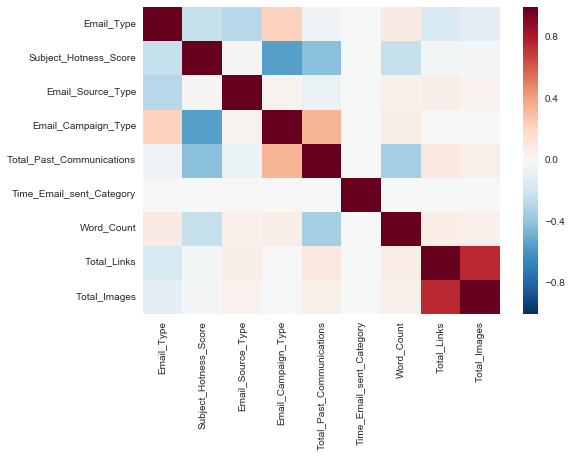

In [10]:
sns.heatmap(allDF.corr())

In [11]:
col_to_drop = ['Email_Type','Email_Source_Type','Customer_Location','Email_Campaign_Type','Time_Email_sent_Category']
#drop_cols_overfitting = ['Total_Links']
drop_cols_overfitting = ['Total_Images']

In [12]:
#Convert customer locatation to categorial.
for col in col_to_drop:
    dummyvar = pd.get_dummies(allDF[col],prefix=col)
    allDF = pd.concat([allDF,dummyvar],axis=1)

allDF = allDF.drop(col_to_drop, axis=1)
allDF = allDF.drop(drop_cols_overfitting, axis=1)

In [13]:
allDF.columns

Index(['Subject_Hotness_Score', 'Total_Past_Communications', 'Word_Count',
       'Total_Links', 'tag', 'Email_Type_1', 'Email_Type_2',
       'Email_Source_Type_1', 'Email_Source_Type_2', 'Customer_Location_A',
       'Customer_Location_B', 'Customer_Location_C', 'Customer_Location_D',
       'Customer_Location_E', 'Customer_Location_F', 'Customer_Location_G',
       'Customer_Location_H', 'Customer_Location_unknown',
       'Email_Campaign_Type_1', 'Email_Campaign_Type_2',
       'Email_Campaign_Type_3', 'Time_Email_sent_Category_1',
       'Time_Email_sent_Category_2', 'Time_Email_sent_Category_3'],
      dtype='object')

In [14]:
#Split, train and test data
X_train = allDF[allDF['tag'] == 'train'].drop('tag',axis=1)
y_train = target
X_test = allDF[allDF['tag'] == 'test'].drop('tag',axis=1)

In [15]:
X_test.shape

(45978, 23)

In [16]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=10):
    
    if useTrainCV:
        cv_score = cross_validation.cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='accuracy')
        print(cv_score.mean())
        #print('estimaters : '+str(cv_score.shape[0]))
        #alg.set_params(n_estimators=cv_score.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y_train.values, dtrain_predictions,labels=[0,1,2]))
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [17]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_features=13)

0.815531200126

Model Report
Accuracy : 0.8169
Confusion matrix:
[[54108   833     0]
 [ 9315  1724     0]
 [ 1818   550     5]]


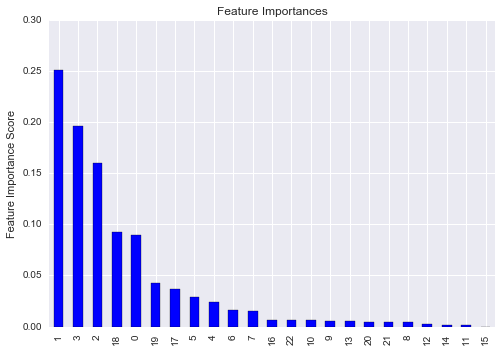

In [18]:
modelfit(gbm,X_train,y_train)

In [ ]:
gbm.get_params()

{'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 13,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param_test1 = {
 'max_depth': list(range(2,9,2)),
    'min_samples_split' : list(range(1,8,2))
}
gsearch1 = GridSearchCV(estimator = gbm, 
 param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
status = gbm.predict(X_test)

In [ ]:
submission = pd.DataFrame()

In [ ]:
status

In [ ]:
submission['Email_ID'] = emailids
submission['Email_Status'] = status

In [ ]:
submission.to_csv('gbm1.csv', index=False)